In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
stratified_results_dir = os.path.join(cfg.repo_root, 'stratified_results', 'pancancer')

In [3]:
vogelstein_df = (
    au.load_prediction_results(stratified_results_dir, 'stratified')
      .assign(gene_dataset='vogelstein')
      .drop(columns=['holdout_cancer_type', 'identifier'])
)
vogelstein_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,train_set,gene_dataset
0,0.95513,0.70461,MAP3K1,signal,42,train,0,stratified,vogelstein
1,0.69504,0.32503,MAP3K1,signal,42,test,0,stratified,vogelstein
2,0.68868,0.29750,MAP3K1,signal,42,cv,0,stratified,vogelstein
3,0.98730,0.90617,MAP3K1,signal,42,train,1,stratified,vogelstein
4,0.78217,0.42547,MAP3K1,signal,42,test,1,stratified,vogelstein


In [16]:
results_df = au.compare_results(vogelstein_df, metric='aupr', correction=True,
                                correction_method='fdr_bh', correction_alpha=0.001,
                                verbose=True)
results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for MSH2, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping


,identifier,delta_mean,p_value,corr_pval,reject_null
76,PTEN,0.584143,5.035824e-10,3.419569e-08,True
31,ERBB2,0.576282,7.199093e-10,3.419569e-08,True
33,FBXW7,0.375389,8.646156e-09,2.178117e-07,True
10,ATRX,0.454540,9.171020e-09,2.178117e-07,True
22,CDKN2A,0.372670,2.249623e-08,4.274284e-07,True
91,TP53,0.406067,2.905414e-08,4.600238e-07,True
26,CTNNB1,0.604498,3.703337e-08,5.025958e-07,True
15,BRAF,0.602992,6.062337e-08,7.199025e-07,True
3,APC,0.587600,7.117884e-08,7.513322e-07,True
48,IDH1,0.445233,1.083661e-07,1.029478e-06,True


Text(0.5, 1.0, 'Metric change and t-test p-value, stratified pan-cancer vs. control')

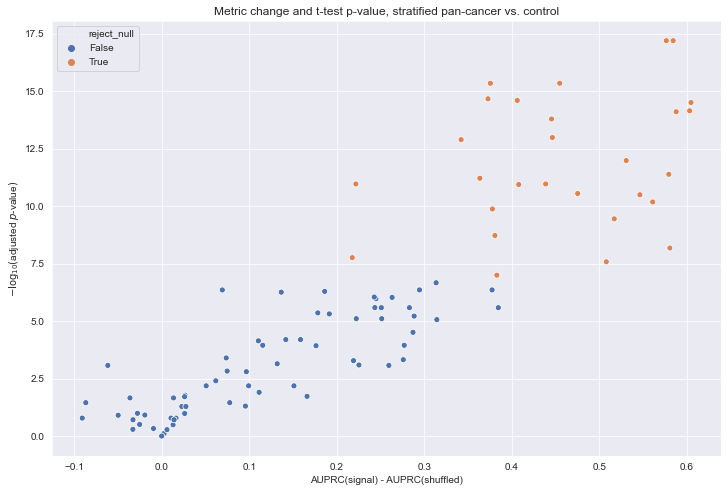

In [17]:
results_df['nlog10_p'] = -np.log(results_df.corr_pval)

sns.set({'figure.figsize': (12, 8)})
sns.scatterplot(data=results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(signal) - AUPRC(shuffled)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.legend()
plt.title(r'Metric change and t-test p-value, stratified pan-cancer vs. control')